In [230]:
#!c1.8
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [231]:
#!c1.8
from pathlib import Path  
import numpy as np  
import torch 
from torch.utils.data import Dataset, DataLoader 
from torch.utils.data.dataset import Subset 
from torchvision.datasets import ImageFolder 
from torchvision.transforms import Compose, RandomResizedCrop, RandomVerticalFlip, RandomHorizontalFlip 
from torchvision.transforms import ColorJitter, ToTensor, Normalize  
import torch.nn as nn 

Формируем датасеты

In [232]:
#!c1.8
import splitfolders

input_folder = 'Images/'
splitfolders.ratio(input_folder, 'images_splited', ratio = (0.65, 0.2, 0.15), seed=13, group_prefix=None)

Copying files: 17712 files [00:52, 338.43 files/s]


In [240]:
#!c1.8
import torchvision
from torchvision import transforms, models

train_dir = 'images_splited/train'
val_dir = 'images_splited/val'
test_dir = 'images_splited/test'

image_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(1),
    transforms.ToTensor()
])

target_transforms = transforms.Lambda(lambda x: x-1)

train_dataset = torchvision.datasets.ImageFolder(train_dir, image_transforms, target_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, image_transforms, target_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_dir, image_transforms, target_transforms)

In [241]:
#!c1.8
!ls 'images_splited/train'

Inter	    Nunito    Oswald  Raleway  SourceSansPro
Montserrat  OpenSans  PTSans  Roboto   Ubuntu


In [242]:
#!c1.8
import torch
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)

In [243]:
#!c1.8
len(train_dataloader)

1439

In [244]:
#!c1.8
len(train_dataset)

11509

In [245]:
#!c1.8
import matplotlib.pyplot as plt
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

tensor(0)


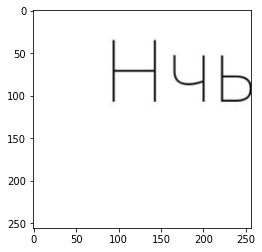

In [246]:
#!c1.8
X_batch, y_batch = next(iter(train_dataloader))
show_input(X_batch[0])
print(y_batch[0])

Определяем нашу нейронную сеть

In [247]:
#!c1.8
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = torch.nn.BatchNorm2d(num_features=32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(num_features=64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(num_features=128)
        
        self.flatten = torch.nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=32 * 32 * 128, out_features=128)
        self.fc2 = nn.Linear(128, 10)
        
        self.drop = torch.nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.bn2(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        
        x = self.drop(x)
        return x

In [248]:
#!c1.8
model = LeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
criterion = nn.CrossEntropyLoss()

process_function для обработки одного батча и служит для реализации проходов по обучающей выборке - только определяет необходимые объекты без запуска обучения. Для дальнейшего запуска на движке Engine

In [249]:
#!c1.8
from ignite.engine import Engine, _prepare_batch  
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def process_function(engine, batch):     
    model.train()     
    optimizer.zero_grad()     
    x, y = _prepare_batch(batch, device=device)     
    y_pred = model(x)     
    loss = criterion(y_pred, y)     
    loss.backward()     
    optimizer.step()     
    return loss.item()  

trainer = Engine(process_function)

Вывод на экран значения функции потерь

In [250]:
#!c1.8
#from ignite.engine import Events
#log_interval = 500
#@trainer.on(Events.ITERATION_COMPLETED) 
#def log_training_loss(engine):     
#    iteration = (engine.state.iteration - 1) % len(train_dataloader) + 1     
#    if iteration % log_interval == 0:         
#        print("Epoch[{}] Iteration[{}/{}] Loss: {:.4f}"               
#              .format(engine.state.epoch,                          
#                      iteration,                           
#                      len(train_dataloader),                           
#                      engine.state.output))

Определяем метрики, которые будем печать в процессе обучения

In [251]:
#!c1.8
from ignite.metrics import Loss, Accuracy, Precision, Recall
metrics = {     
    'avg_loss': Loss(criterion),     
    'avg_accuracy': Accuracy(),     
    'avg_precision': Precision(average=True),     
    'avg_recall': Recall(average=True) 
}

Создаем два движка для оценки модели. Мы создаем два движка для того, чтобы на один из них (val_evaluator) далее прицепить дополнительные обработчики событий для сохранения модели и ранней остановки обучения

In [252]:
#!c1.8
from ignite.engine import create_supervised_evaluator
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

Выберем случайным образом часть обучающей выборки, на которой будем вычислять метрики

In [253]:
#!c1.8
import numpy as np
from torch.utils.data.dataset import Subset
indices = np.arange(len(train_dataset))
random_indices = np.random.permutation(indices)[:len(val_dataset)]

train_subset = Subset(train_dataset, indices=random_indices)

train_eval_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                num_workers=batch_size, 
                                drop_last=True)

Определим запуск вычисления и вывода метрик в конце эпохи

In [254]:
#!c1.8
from ignite.engine import Events
@trainer.on(Events.EPOCH_COMPLETED) 
def compute_and_display_offline_train_metrics(engine):
    epoch = engine.state.epoch     
    print("Compute train metrics...") 
    metrics = train_evaluator.run(train_eval_loader).metrics  
    print("Training Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"  
          .format(engine.state.epoch,                    
                  metrics['avg_loss'],   
                  metrics['avg_accuracy'],   
                  metrics['avg_precision'],  
                  metrics['avg_recall']))  
@trainer.on(Events.EPOCH_COMPLETED) 
def compute_and_display_val_metrics(engine): 
    epoch = engine.state.epoch    
    print("Compute validation metrics...")  
    metrics = val_evaluator.run(val_dataloader).metrics   
    print("Validation Results - Epoch: {}  Average Loss: {:.4f} | Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f}"  
          .format(engine.state.epoch,                     
                  metrics['avg_loss'],                   
                  metrics['avg_accuracy'],                
                  metrics['avg_precision'],     
                  metrics['avg_recall'])) 

Изменяем скорость обучения в начале каждой эпохи

In [255]:
#!c1.8
from torch.optim.lr_scheduler import ExponentialLR

lr_scheduler = ExponentialLR(optimizer, gamma=0.8)

@trainer.on(Events.EPOCH_STARTED)
def update_lr_scheduler(engine):
    lr_scheduler.step()
    # Вывод значений скорости обучения:
    if len(optimizer.param_groups) == 1:
        lr = float(optimizer.param_groups[0]['lr'])
        print("Learning rate: {}".format(lr))
    else:
        for i, param_group in enumerate(optimizer.param_groups):
            lr = float(param_group['lr'])
            print("Learning rate (group {}): {}".format(i, lr))

Сохраняем лучшую модель

In [256]:
#!c1.8
from ignite.handlers import ModelCheckpoint

def score_function(engine):
    val_avg_accuracy = engine.state.metrics['avg_accuracy']
    return val_avg_accuracy

best_model_saver = ModelCheckpoint("models",  
                                   filename_prefix="model",
                                   score_name="val_accuracy",  
                                   score_function=score_function,
                                   n_saved=3,
                                   #save_as_state_dict=True,
                                   create_dir=True,
                                   require_empty=False)
# "best_models" - Папка куда сохранять 1 или несколько лучших моделей
# Имя файла -> {filename_prefix}_{name}_{step_number}_{score_name}={abs(score_function_result)}.pth
# save_as_state_dict=True,  # Сохранять как `state_dict`

val_evaluator.add_event_handler(Events.COMPLETED, 
                                best_model_saver, 
                                {"best_model": model})

Ранняя остановка обучения если не будет улучшений на протяжении 20 эпох 

In [257]:
#!c1.8
from ignite.handlers import EarlyStopping

early_stopping = EarlyStopping(patience=20, 
                              score_function=score_function, 
                              trainer=trainer)

val_evaluator.add_event_handler(Events.EPOCH_COMPLETED, early_stopping)

In [258]:
#!c1.8
output = trainer.run(train_dataloader, max_epochs=100)

Learning rate: 0.0008
Compute train metrics...
Training Results - Epoch: 1  Average Loss: 2.4437 | Accuracy: 0.1343 | Precision: 0.1312 | Recall: 0.1186
Compute validation metrics...
Validation Results - Epoch: 1  Average Loss: 2.4645 | Accuracy: 0.1125 | Precision: 0.1037 | Recall: 0.1004
Learning rate: 0.00064
Compute train metrics...
Training Results - Epoch: 2  Average Loss: 2.2129 | Accuracy: 0.1864 | Precision: 0.1580 | Recall: 0.1679
Compute validation metrics...
Validation Results - Epoch: 2  Average Loss: 2.2523 | Accuracy: 0.1574 | Precision: 0.1375 | Recall: 0.1415
Learning rate: 0.0005120000000000001
Compute train metrics...
Training Results - Epoch: 3  Average Loss: 2.2106 | Accuracy: 0.2053 | Precision: 0.1834 | Recall: 0.1805
Compute validation metrics...
Validation Results - Epoch: 3  Average Loss: 2.2577 | Accuracy: 0.1919 | Precision: 0.1540 | Recall: 0.1698
Learning rate: 0.0004096000000000001
Compute train metrics...
Training Results - Epoch: 4  Average Loss: 1.9552

2022-05-17 09:38:28,864 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Загрузка

In [220]:
#!c1.8
the_model = LeNet()
the_model.load_state_dict(torch.load('models/lenet'))

<All keys matched successfully>

In [228]:
#!c1.8
def print_history(test_history):
    plt.plot(test_accuracy_history);

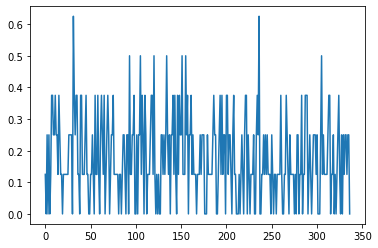

In [229]:
#!c1.8
print_accuracy(test_accuracy_history)